 <p style="margin: 0; padding: 0; background-color: black; color: white; text-align: left; font-size: 2em; padding: 20px;">
  Predict Model </p>

## Load Important Libraries and Data

In [1]:
# data loading and wrangling libraries for EDA
import pandas as pd
import numpy as np

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# data splitting
from sklearn.model_selection import train_test_split

# ml models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Cross validation
from sklearn.model_selection import KFold, cross_val_score

# ML model evaluation
from sklearn.metrics import accuracy_score, classification_report

# warnings
import warnings
warnings.filterwarnings('ignore')

# Loading the data
df = pd.read_excel(r'C:\Users\MohammedR\Desktop\IABAC PROJECT\data\processed\INX_future_inc_employee_cleaned_dataset.xlsx')

In [2]:
df.head()

,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,4,...,4,10,2,2,10,7,0,8,No,3
1,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,4,...,4,20,2,3,7,7,1,7,No,3
2,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,4,...,3,20,2,3,18,13,1,12,No,4
3,41,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,10,4,2,...,2,23,2,2,21,6,12,6,No,3
4,60,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,16,4,1,...,4,10,1,3,2,2,2,2,No,3


## Preprocessing the data for ML models

In [3]:
# lets prepare our dataset into categorical and numerical data

cat_df = df.select_dtypes(['object','bool'])
num_df = df.select_dtypes(['int64', 'float64'])

# Applying the OneHotEncoding technique for Categorical features
cat_df = pd.get_dummies(cat_df)

# concatonate the categorical and numerical datasets to make one prepared dataset for RandomForest model
ml_df = pd.concat([cat_df, num_df], axis=1)

# Splitting the dataset into X=features and y=target 
X = ml_df.iloc[:, :-1]
y = ml_df.PerformanceRating

# now lets perform the train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=44)

## Balancing the dataset using imblearn

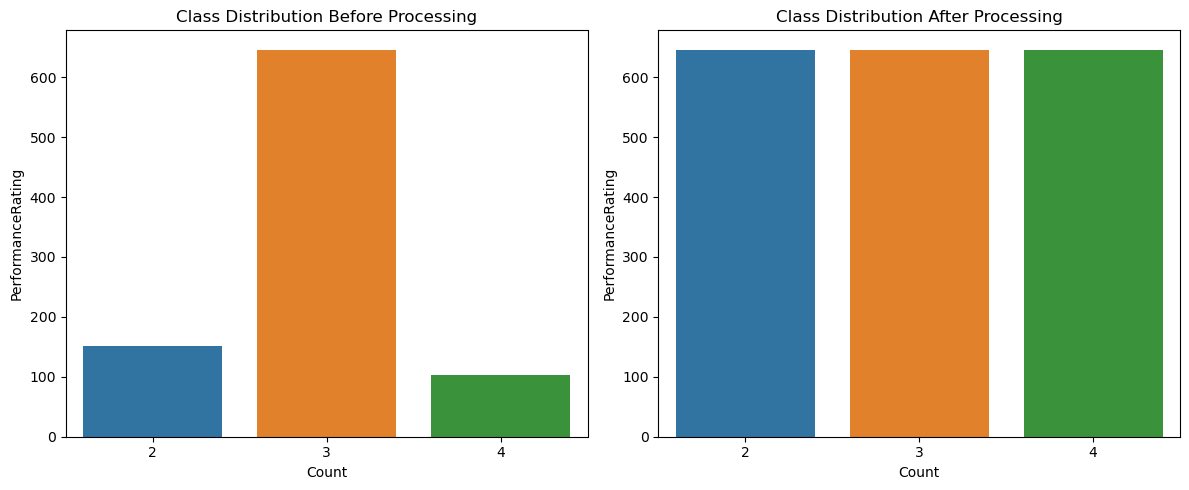

In [4]:
# Define oversampling and undersampling techniques
oversampling = SMOTE()
undersampling = RandomUnderSampler()

# Define pipeline steps
steps = (('o', oversampling), ('u', undersampling))
pipeline = Pipeline(steps=steps)

# Apply the pipeline
X_bal, y_bal = pipeline.fit_resample(X_train, y_train)

# Visualization of class distribution before and after processing
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before processing
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Class Distribution Before Processing')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('PerformanceRating')

# After processing
sns.countplot(x=y_bal, ax=axes[1])
axes[1].set_title('Class Distribution After Processing')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('PerformanceRating')

plt.tight_layout()
plt.show()

## Training and prediction using GradientBoostClassifier

In [5]:
# Define model parameter dict
gb_best_params = {
    'subsample': 1, 
    'n_estimators': 900, 
    'min_samples_leaf': 3, 
    'max_features': 'sqrt', 
    'max_depth': 9, 
    'learning_rate': 0.1, 
    'criterion': 'squared_error'
}
    
# Define the GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(**gb_best_params)  

'''The double asterisks ** unpack the dictionary, 
and each key-value pair in the dictionary becomes a separate 
keyword argument for the XGBClassifier constructor.'''


# Train the model
gb_clf.fit(X_bal, y_bal)

y_predict_test = gb_clf.predict(X_test)

print("Test Accuracy",accuracy_score(y_test, y_predict_test))
print(classification_report(y_test, y_predict_test))

Test Accuracy 0.9133333333333333
              precision    recall  f1-score   support

           2       0.80      0.86      0.83        43
           3       0.96      0.93      0.94       228
           4       0.77      0.83      0.80        29

    accuracy                           0.91       300
   macro avg       0.84      0.87      0.86       300
weighted avg       0.92      0.91      0.91       300



In [6]:
gbprediction = pd.DataFrame({'predicted_values':y_predict_test, 'actual_values':y_test})
gbprediction

,predicted_values,actual_values
976,3,3
651,4,4
139,3,3
265,3,3
834,3,3
...,...,...
64,3,3
1047,3,3
997,3,2
286,3,3


## Training with XGBoost Classifier

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

#Encoding the target variable for train and test into [0,1,2] class instead of [2,3,4] to be recognised by the XGBoost ML
y_bal_encoded = label_encoder.fit_transform(y_bal)
y_test_encoded = label_encoder.fit_transform(y_test)

In [8]:
# Define model parameter dict
xgb_best_params = {
    'subsample': 0.8666666666666667, 
    'n_estimators': 700, 
    'min_child_weight': 2, 
    'max_depth': 9, 
    'learning_rate': 0.24770763559917114, 
    'colsample_bytree': 0.9333333333333333
}

# Define the GradientBoostingClassifier with the parameters
xgb_clf = XGBClassifier(**xgb_best_params)

# Train the model
xgb_clf.fit(X_bal, y_bal_encoded)

y_predict_test = xgb_clf.predict(X_test)

print("Test Accuracy",accuracy_score(y_test_encoded, y_predict_test))
print(classification_report(y_test_encoded, y_predict_test))

Test Accuracy 0.9066666666666666
              precision    recall  f1-score   support

           0       0.80      0.81      0.80        43
           1       0.94      0.93      0.94       228
           2       0.80      0.83      0.81        29

    accuracy                           0.91       300
   macro avg       0.85      0.86      0.85       300
weighted avg       0.91      0.91      0.91       300



In [9]:
xgbprediction = pd.DataFrame({'predicted_values':y_predict_test, 'actual_values':y_test_encoded})
xgbprediction

,predicted_values,actual_values
0,1,1
1,2,2
2,1,1
3,1,1
4,1,1
...,...,...
295,1,1
296,1,1
297,1,0
298,1,1
